In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from tqdm import tqdm

import os
import shutil
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5TokenizerFast

2025-09-22 10:58:48.811177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758538728.978826      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758538729.030609      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Формируем датасет и подгружаем модель

In [2]:
# Задаем сид
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Переносим обучение на GPU (GPU P100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#загружаем данные из датасета - englishrussian-dictionary-for-machine-translate
path = "/kaggle/input/englishrussian-dictionary-for-machine-translate/rus.txt"

with open(path, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# Проверяем записи в прочитанном тесте
text[:150]

'Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)\nGo.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #28'

In [5]:
# Подготавливаем список фраз к дальнейшему формированию features и targets

lines = text.split("\n")

phrases = []

idxs_of_eng_phrases = np.random.choice(int(len(text)), 30000)

for i, line in enumerate(lines):
    line_splited = line.split("\t")
    # убираем последний символ каждой строки, если это точка, переводим все в нижний регистр
    if len(line_splited) > 2:
        
        if line_splited[0][-1] == ".":
            line_splited[0] = line_splited[0][:-1]
    
        if line_splited[1][-1] == ".":
            line_splited[1] = line_splited[1][:-1]
            
        line_splited[0] = line_splited[0].lower()
        line_splited[1] = line_splited[1].lower()
    
        # добавляем русские и английские фразы в список фраз
        # английских слов добавляем немного, так как в проверочном они присутствуют менее чем в 100 строках
        phrases.append(line_splited[1])
        
        if i in idxs_of_eng_phrases:
            phrases.append(line_splited[0])

In [6]:
# Уберем все дубликаты фраз
phrases = list(set(phrases))

print(f"Размер датасета - {len(phrases)} фраз")

Размер датасета - 325828 фраз


In [7]:
# пример некоторых фраз в списке
phrases[300:305]

['это не похоже на тома',
 'может быть, вам стоит сделать это вместе',
 'том не оставил сообщения',
 'она разделась',
 'у меня пропали ботинки']

In [8]:
# Так как будет использоваться модель формата энкодер-декодер, на вход модели будет подаваться
# Слитная фраза, а на выходе мы будем получать данную фразу, но с пробелами, значит
# targets - это копия списка pharses
# features - это данный список, но со слитно написанными фразами

targets = phrases.copy()

features = []
for phrase in phrases:
    phrase = "".join(phrase.split())
    # features.append("Correctly split a continuous phrase in Russian into separate words using spaces | " + phrase)
    features.append(phrase)

print(f"Пример входной фразы: {features[10000]}")
print(f"Пример фразы, которую должна получить на выходе модели: {targets[10000]}")

Пример входной фразы: никтоизнаснехочетделатьэтосегодня
Пример фразы, которую должна получить на выходе модели: никто из нас не хочет делать это сегодня


In [9]:
# MODEL_PATH = "/kaggle/input/flan-t5/pytorch/small/2"
# model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)
# tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)

tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-multitask")

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00002)

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

In [10]:
# # определяю подходящую максимальную длину для токенов при обучении модели, беру по таргету так они длиннее

tokenizer = T5TokenizerFast.from_pretrained("cointegrated/rut5-base-multitask")
lengths = [len(tokenizer.encode(s, truncation=False)) for s in targets]

for p in [50, 75, 90, 95, 99]:
    print(f'Перцентиль данных выборки {p}: | необходимое количество токенов: {np.percentile(lengths, p)}')

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Перцентиль данных выборки 50: | необходимое количество токенов: 10.0
Перцентиль данных выборки 75: | необходимое количество токенов: 13.0
Перцентиль данных выборки 90: | необходимое количество токенов: 16.0
Перцентиль данных выборки 95: | необходимое количество токенов: 18.0
Перцентиль данных выборки 99: | необходимое количество токенов: 23.0


In [25]:
# Добавим вспомогательные функции для определения пробелов в корректных местах, согласно заданию и расчету метрики F1

# Исходя из длины запросов в проверочном файле, можно заключить, что запас в 40 токенов может гарантировать, что обрезки ответа не будет
max_len = 23
save_dir = "/kaggle/working/"
pad_id = tokenizer.pad_token_id

# функция предтокенизации для ускорения обучения
def pretokenize_dataset(dataset):
    inputs = []
    for x,y in dataset:  # dataset — iterable пар (x_text, y_text)
        enc = tokenizer(x, truncation=True, max_length=max_len, padding="max_length", return_tensors="pt")
        dec = tokenizer(y, truncation=True, max_length=max_len, padding="max_length", return_tensors="pt")
        labels = dec["input_ids"].squeeze(0)
        labels[labels == pad_id] = -100
        inputs.append({
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": labels,
            "y_text": y
        })
    return inputs

# Функция перевода текст с пробелами в список индексов мест, где находятся пробелы
def define_spaces(spaced_string):
    previous_spased = [i for i,ch in enumerate(spaced_string) if ch == " "]
    for idx in range(len(previous_spased)):
        previous_spased[idx] -= idx

    return previous_spased

# Функция расчета F1 метрику для результатов предсказаний
def f1_metrics(pred_spaces, target_spaces):
    tp = fp = fn = 0
    
    for p,g in zip(pred_spaces, target_spaces):
        pset = set(define_spaces(p))
        gset = set(define_spaces(g))
        tp += len(pset & gset)
        fp += len(pset - gset)
        fn += len(gset - pset)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
    
    return {"precision": prec, "recall": rec, "f1": f1}

In [12]:
# Формируем датасет, переводим его в токены и загружаем в даталоадер
class MyDataset(data.Dataset):
    def __init__(self):
        self.features = features
        self.targets = targets
        self.length = len(self.features)

    def __getitem__(self, index):
        return (self.features[index], self.targets[index])

    def __len__(self):
        return self.length

d_data = MyDataset()

# берем только часть датасета для ускорения обучения (50% от датасета)
d_train, d_val, _ = data.random_split(d_data, [0.45, 0.05, 0.5])

train_tokens = pretokenize_dataset(d_train)
val_tokens = pretokenize_dataset(d_val)

train_loader = data.DataLoader(train_tokens, 64, shuffle=True, drop_last=True)
test_loader = data.DataLoader(val_tokens, 64, shuffle=False)


## Скрипт дообучения нейросети

In [13]:
# скрипт обучения модели
epoch = 10

losses_train = []
losses_val = []
exacts = []
f_ones = []
precisions = []
recalls = []

print("--|-----------------------------|--")

for _e in range(1, epoch + 1):
    
    # Обучение
    model.train()
    loss_value = 0.0
    num_batches = 0
    pbar = tqdm(train_loader, desc=f"Epoch {_e} train", leave=True)

    for batch in pbar:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        labels[labels == tokenizer.pad_token_id] = -100

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        num_batches += 1
        pbar.set_postfix({"loss": loss_value / num_batches})

    avg_loss = loss_value / max(1, num_batches)
    losses_train.append(avg_loss)

    
    # Валидация
    model.eval()
    pred_spaces = []
    target_spaces = []

    val_loss_sum = 0.0
    val_batches = 0

    with torch.no_grad():
        val_pbar = tqdm(test_loader, desc=f"Epoch {_e} val", leave=True)
        
        for batch in val_pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs_val = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs_val.loss.item()
            val_loss_sum += val_loss
            val_batches += 1

            val_pbar.set_postfix({"loss": val_loss_sum / val_batches})
            
            gen_ids = model.generate(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                max_length=max_len,
                num_beams=1,
                no_repeat_ngram_size=0
            )
            gen_ids = gen_ids.cpu()
            decoded = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

            for d in decoded:
                pred_spaces.append(d)
            
            for t in batch["y_text"]:
                target_spaces.append(t)

    avg_val_loss = val_loss_sum / max(1, val_batches)
    losses_val.append(avg_val_loss)

    # Расчет метрик обучения
    exact = sum(1 for p,g in zip(pred_spaces, target_spaces) if p == g) / len(target_spaces)
    bmetrics = f1_metrics(pred_spaces, target_spaces)
    idx = random.choice(range(len(target_spaces)))
    print(f"Predict: {pred_spaces[idx]}")
    print(f"Target: {target_spaces[idx]}")

    exacts.append(exact)
    f_ones.append(bmetrics['f1'])
    precisions.append(bmetrics['precision'])
    recalls.append(bmetrics['recall'])

    print(f"exact_match={exact:.4f} f1={bmetrics['f1']:.4f} (P={bmetrics['precision']:.4f}, R={bmetrics['recall']:.4f})")
    print("--|-----------------------------|--")

print("Training finished. Best exact:", exact)

# сохраняем модель
model_path = os.path.join(save_dir, "best_model")

print(f"New model. Saving to {model_path}")

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

--|-----------------------------|--


Epoch 1 val: 100%|██████████| 255/255 [02:17<00:00,  1.86it/s, loss=0.157]


Predict: том знает, что мне всё равно
Target: том знает, что мне всё равно
exact_match=0.7591 f1=0.9029 (P=0.9118, R=0.8942)
--|-----------------------------|--


Epoch 2 val: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss=0.111]


Predict: она меня бросила
Target: она меня бросила
exact_match=0.8315 f1=0.9327 (P=0.9393, R=0.9262)
--|-----------------------------|--


Epoch 3 val: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss=0.086] 


Predict: заключённые были освободены
Target: заключённые были освобождены
exact_match=0.8645 f1=0.9461 (P=0.9512, R=0.9411)
--|-----------------------------|--


Epoch 4 val: 100%|██████████| 255/255 [02:15<00:00,  1.88it/s, loss=0.0726]


Predict: скажи мне, что у тебя за проблема
Target: скажи мне, что у тебя за проблема
exact_match=0.8875 f1=0.9552 (P=0.9594, R=0.9510)
--|-----------------------------|--


Epoch 5 val: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss=0.0639]


Predict: я никогда никому не причиняла вреда
Target: я никогда никому не причиняла вреда
exact_match=0.9001 f1=0.9607 (P=0.9649, R=0.9565)
--|-----------------------------|--


Epoch 6 val: 100%|██████████| 255/255 [02:16<00:00,  1.86it/s, loss=0.0555]


Predict: один из нас должен идти
Target: один из нас должен идти
exact_match=0.9114 f1=0.9656 (P=0.9695, R=0.9618)
--|-----------------------------|--


Epoch 7 val: 100%|██████████| 255/255 [02:17<00:00,  1.85it/s, loss=0.0508]


Predict: это действительно помогло
Target: это действительно помогло
exact_match=0.9195 f1=0.9687 (P=0.9722, R=0.9652)
--|-----------------------------|--


Epoch 8 val: 100%|██████████| 255/255 [02:17<00:00,  1.85it/s, loss=0.0473]


Predict: я не игнорировал тома
Target: я не игнорировал тома
exact_match=0.9241 f1=0.9715 (P=0.9755, R=0.9676)
--|-----------------------------|--


Epoch 9 val: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss=0.0466]


Predict: кто, как ты думаешь, будет на вечеринке?
Target: кто, как ты думаешь, будет на вечеринке?
exact_match=0.9292 f1=0.9728 (P=0.9767, R=0.9689)
--|-----------------------------|--


Epoch 10 val: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss=0.0441]


Predict: я не могу тебе точно сказать, сколько времени это займёт
Target: я не могу тебе точно сказать, сколько времени это займёт
exact_match=0.9337 f1=0.9751 (P=0.9789, R=0.9713)
--|-----------------------------|--
Training finished. Best exact: 0.9337057270885765
New model. Saving to /kaggle/working/best_model


('/kaggle/working/best_model/tokenizer_config.json',
 '/kaggle/working/best_model/special_tokens_map.json',
 '/kaggle/working/best_model/spiece.model',
 '/kaggle/working/best_model/added_tokens.json',
 '/kaggle/working/best_model/tokenizer.json')

In [14]:
# Сохраняю архив с моделью
save_dir = "/kaggle/working"
model_folder = "best_model"
model_path = os.path.join(save_dir, model_folder)

archive_base = os.path.join("/kaggle/working", model_folder)
zip_path = shutil.make_archive(archive_base, 'zip', root_dir=save_dir, base_dir=model_folder)

In [21]:
# Формирую ссылку для скачивания модели так как файл напрямую не хочет скачиваться из /kaggle/working
from IPython.display import FileLink
FileLink(r'best_model.zip')

/kaggle/working/best_model.zip

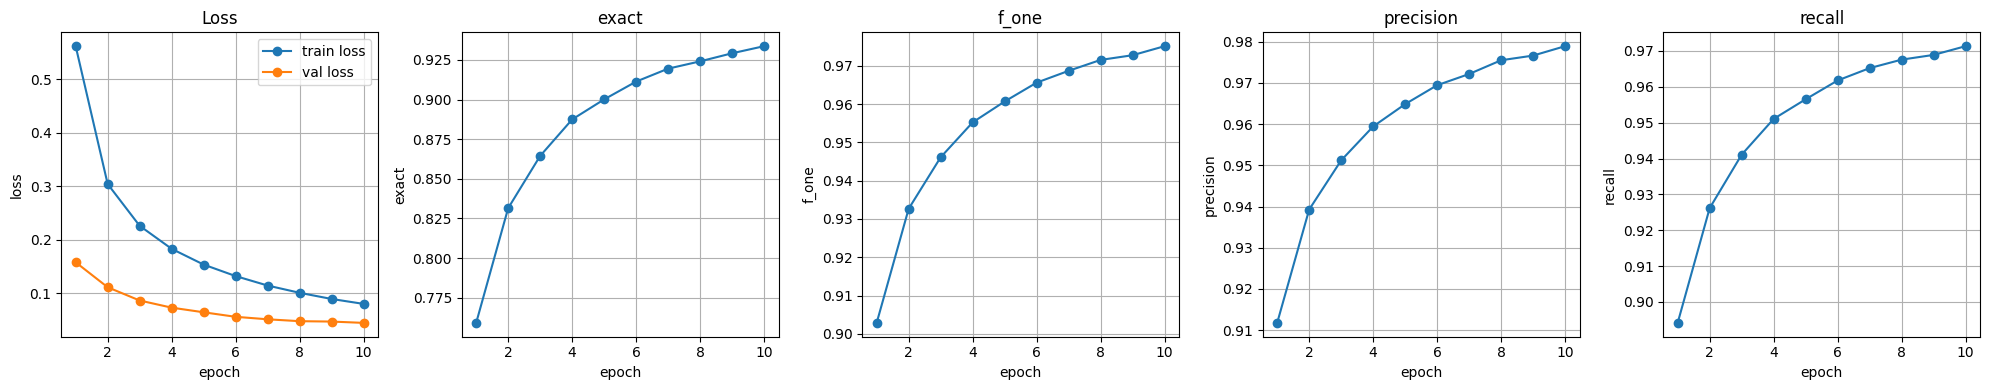

In [15]:
# Построение результирующих графиков

epochs = range(1, epoch + 1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

ax0 = axes[0]
ax0.plot(epochs, losses_train, marker='o', label='train loss')
ax0.plot(epochs, losses_val, marker='o', label='val loss')
ax0.set_title('Loss')
ax0.set_xlabel('epoch')
ax0.set_ylabel('loss')
ax0.grid(True)
ax0.legend()

metrics = {
    "exact": exacts,
    "f_one": f_ones,
    "precision": precisions,
    "recall": recalls
}

for ax, (name, vals) in zip(axes[1:], metrics.items()):
    ax.plot(epochs, vals, marker='o', linewidth=1.5)
    ax.set_title(name)
    ax.set_xlabel("epoch")
    ax.set_ylabel(name)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Работа сети

In [16]:
# Функция работы нейросети

def predict_with_spaces(text, model, tokenizer, device=device, max_len = 40):

    model.eval()

    with torch.no_grad():
        enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
        enc = {k: v.to(device) for k, v in enc.items()}

        gen_ids = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc.get("attention_mask", None),
            max_length=max_len,
            num_beams=1,
            no_repeat_ngram_size=0
        )

        gen_ids = gen_ids.cpu()
        decoded = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

        predict = decoded[0] if len(decoded) > 0 else ""
        spaced_predict = define_spaces(predict)

        return predict, spaced_predict

In [26]:
model_path = "/kaggle/working/best_model"

tokenizer_saved = T5Tokenizer.from_pretrained(model_path)
model_saved = T5ForConditionalGeneration.from_pretrained(model_path)

model_saved.to(device)
model_saved.eval()

test_str = "книгавхорошемстотоянии"
test_str_spased = "книга в хорошем состоянии"

pred, spaced_pred = predict_with_spaces(test_str, model, tokenizer)
print(f"target:  {test_str_spased}")
print(f"predict: {pred}")
print(f"target:  {define_spaces(test_str_spased)}")
print(f"predict: {spaced_pred}")

target:  книга в хорошем состоянии
predict: книга в хорошем стетоянии
target:  [5, 6, 13]
predict: [5, 6, 13]


## Submission

In [27]:
# task_data = pd.read_csv("/kaggle/input/submission/dataset_1937770_3.txt")

# Файл для предсказания напрямую командой со степик не читается так как разделитель - запятая 
# и в строках есть запятые и пандас думает, что в строках различное количество столбцов, поэтому сделаем кастомное считываение
path_s = "/kaggle/input/submission/dataset_1937770_3.txt"

with open (path_s, 'r', encoding='utf-8') as f:
    text = f.read()

test_dict = {"id" : [], 
             "predicted_positions" : []}

for i, line in enumerate(text.split("\n")[1:]):
    line_splited = line.split(",")
    
    test_string = ",".join(line_splited[1:])

    test_dict["id"].append(i)

    _, spased_test_predict = predict_with_spaces(test_string.lower(), model, tokenizer)
    test_dict["predicted_positions"].append(spased_test_predict)
    

test_data = pd.DataFrame(test_dict)
# уберем последнюю строку с пробельным символом
test_data = test_data[:-1]
print(test_data[:15])

test_data.to_csv('/kaggle/working/submission.txt', index=False)

    id  predicted_positions
0    0          [5, 10, 12]
1    1            [3, 6, 7]
2    2  [4, 12, 13, 20, 21]
3    3          [5, 10, 18]
4    4              [5, 10]
5    5           [6, 7, 13]
6    6              [5, 14]
7    7          [3, 12, 15]
8    8              [6, 13]
9    9              [5, 12]
10  10          [3, 11, 12]
11  11              [5, 18]
12  12              [6, 12]
13  13              [5, 11]
14  14          [3, 13, 15]


In [28]:
#посмотрим на последние символы
print(test_data[-10:])

        id           predicted_positions
995    995          [5, 6, 7, 8, 13, 16]
996    996          [5, 6, 7, 9, 13, 20]
997    997                 [5, 6, 7, 12]
998    998        [1, 4, 10, 11, 15, 20]
999    999  [3, 4, 7, 8, 11, 12, 16, 20]
1000  1000                        [1, 3]
1001  1001         [5, 6, 7, 10, 12, 16]
1002  1002                [5, 6, 11, 19]
1003  1003             [5, 6, 8, 19, 22]
1004  1004                 [5, 6, 9, 12]


## Последний submission (данные из которого здесь частично напечатаны) после появления описания алгоритма формирования индексов показал данный результат, при использовании сохраненной модели, данный результат подтвердится

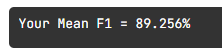